# 👨‍⚕️ Projet Stroke Alert 👩‍⚕️

## 1. Préparation du jeu de données

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
print(f"Le dataFrame comporte {df.shape[0]} lignes, pour {df.shape[1]} colonnes. ")

Le dataFrame comporte 5110 lignes, pour 12 colonnes. 


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### ► Valeurs manquantes

On va remplacer les champs "Unknown" de la colonne "smoking_status" par des N/A. 

In [6]:
df['smoking_status'] = df['smoking_status'].replace('Unknown', np.nan)

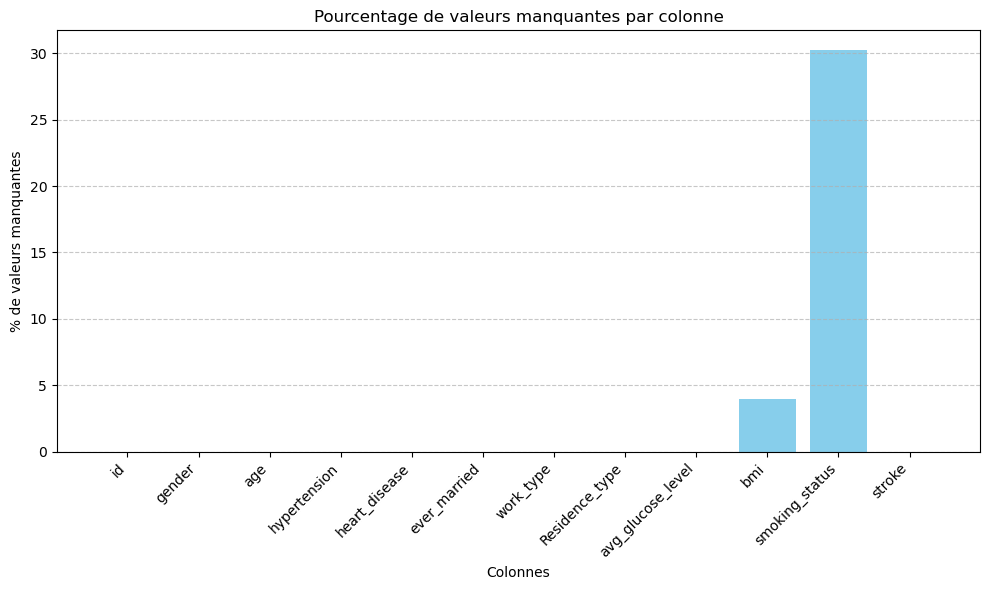

In [7]:
missing_percentages = [(1 - df[column].dropna().shape[0] / df[column].shape[0]) * 100 for column in df.columns]

plt.figure(figsize=(10, 6))
plt.bar(df.columns, missing_percentages, color='skyblue')
plt.xlabel('Colonnes')
plt.ylabel('% de valeurs manquantes')
plt.title('Pourcentage de valeurs manquantes par colonne')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Dans un contexte médical, impossible d'abandonner ces données. Pour L'IMC on pourra imputer la moyenne aux valeurs manquantes.

### ► Outliers

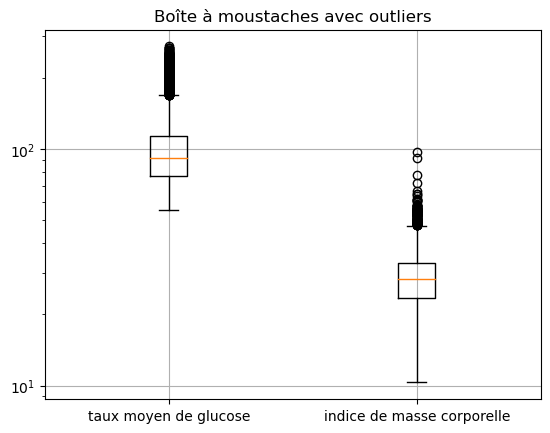

In [8]:
taux_moyen_glucose = df['avg_glucose_level']
indice_masse_corporelle = df['bmi'].dropna()
plt.boxplot([taux_moyen_glucose,indice_masse_corporelle], showfliers=True)
plt.xticks([1,2],['taux moyen de glucose','indice de masse corporelle'])
plt.yscale('log')
plt.title("Boîte à moustaches avec outliers")
plt.grid(True)
plt.show()

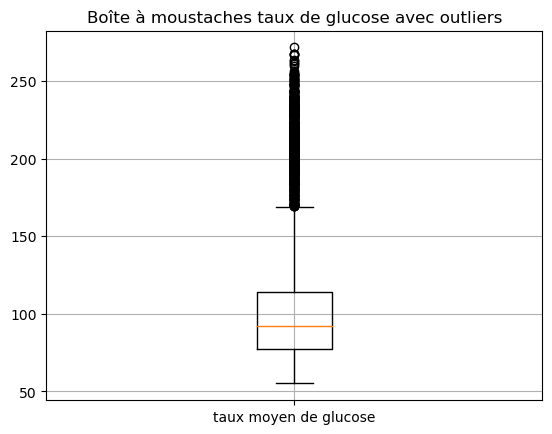

In [9]:
taux_moyen_glucose = df['avg_glucose_level']
plt.boxplot(taux_moyen_glucose, showfliers=True)
plt.xticks([1],['taux moyen de glucose'])
plt.title("Boîte à moustaches taux de glucose avec outliers")
plt.grid(True)
plt.show()

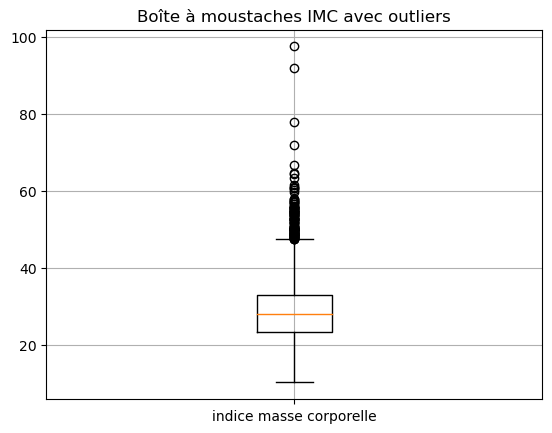

In [10]:
indice_masse_corporelle = df['bmi'].dropna()
plt.boxplot(indice_masse_corporelle, showfliers=True)
plt.xticks([1],['indice masse corporelle'])
plt.title("Boîte à moustaches IMC avec outliers")
plt.grid(True)
plt.show()

In [11]:
df.loc[(df['bmi'] > 50) & (df['stroke'] == 1)].count()

id                   1
gender               1
age                  1
hypertension         1
heart_disease        1
ever_married         1
work_type            1
Residence_type       1
avg_glucose_level    1
bmi                  1
smoking_status       1
stroke               1
dtype: int64

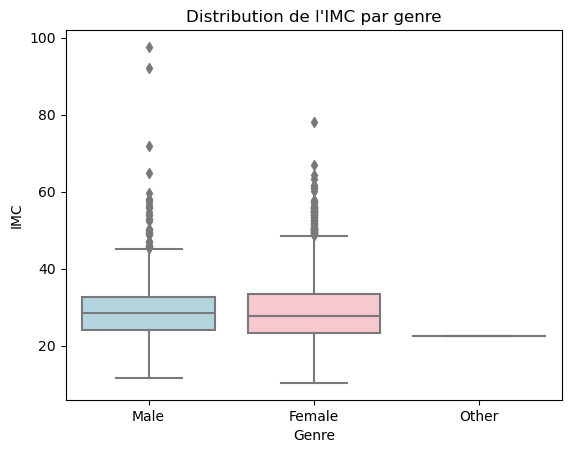

In [12]:
sns.boxplot(data=df, x="gender", y="bmi", palette=['lightblue','pink']);
plt.xlabel("Genre")
plt.ylabel("IMC")
plt.title("Distribution de l'IMC par genre")
plt.show()

Ici, les outliers ne sont pas des valeurs abérantes. On les garde donc dans notre jeu de données.

In [13]:
df_patient_avc = df.loc[df['stroke'] == 1,:]
df_patient_no_avc = df.loc[df['stroke'] == 0,:]
print(f"Dans notre échantillon, il y a {df_patient_avc.shape[0]} patients ayant contracté un AVC.")

Dans notre échantillon, il y a 249 patients ayant contracté un AVC.


## 2. Analyse bivariée par rapport au risque d'avoir un AVC

### ► Genre 

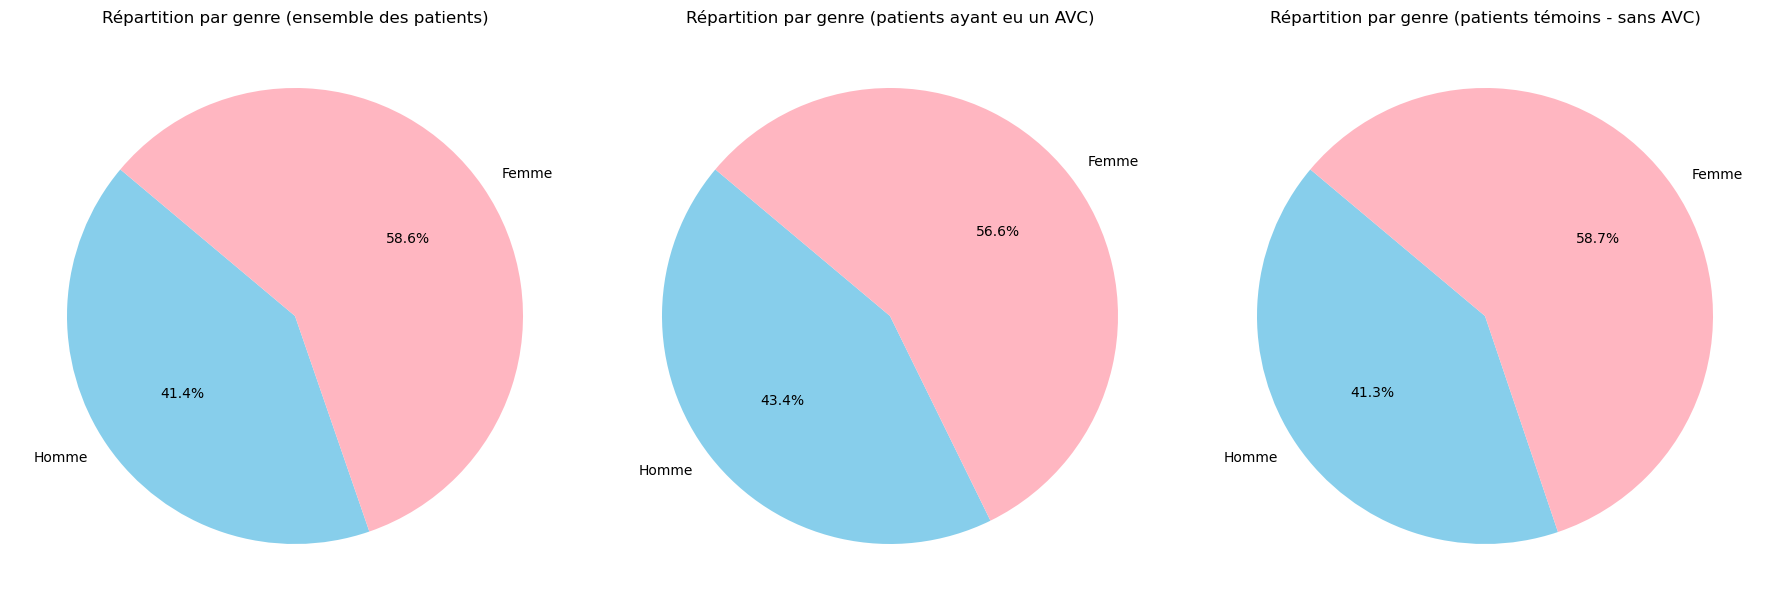

In [14]:
# Données pour le premier camembert (ensemble des patients)
homme_all = (df['gender'] == 'Male').sum()
femme_all = (df['gender'] == 'Female').sum()
nombre_patients_all = [homme_all, femme_all]
labels_all = ['Homme', 'Femme']
colors_all = ['skyblue', 'lightpink']

# Données pour le deuxième camembert (patients ayant eu un AVC)
homme_avc = (df_patient_avc['gender'] == 'Male').sum()
femme_avc = (df_patient_avc['gender'] == 'Female').sum()
nombre_patients_avc = [homme_avc, femme_avc]
labels_avc = ['Homme', 'Femme']
colors_avc = ['skyblue', 'lightpink']

# Données pour le troisième camembert (patients témoins - sans AVC)
homme_no_avc = (df_patient_no_avc['gender'] == 'Male').sum()
femme_no_avc = (df_patient_no_avc['gender'] == 'Female').sum()
nombre_patients_no_avc = [homme_no_avc, femme_no_avc]
labels_no_avc = ['Homme', 'Femme']
colors_no_avc = ['skyblue', 'lightpink']

# Créer le subplot avec trois camemberts
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Premier camembert : ensemble des patients
axs[0].pie(nombre_patients_all, labels=labels_all, colors=colors_all, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Répartition par genre (ensemble des patients)')

# Deuxième camembert : patients ayant eu un AVC
axs[1].pie(nombre_patients_avc, labels=labels_avc, colors=colors_avc, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Répartition par genre (patients ayant eu un AVC)')

# Troisième camembert : patients témoins - sans AVC
axs[2].pie(nombre_patients_no_avc, labels=labels_no_avc, colors=colors_no_avc, autopct='%1.1f%%', startangle=140)
axs[2].set_title('Répartition par genre (patients témoins - sans AVC)')

# Ajuster l'espacement entre les subplots
plt.tight_layout()

# Afficher le subplot
plt.show()

In [15]:
homme_avc = (df.loc[(df['gender'] == 'Male') & (df['stroke'] == 1),'stroke']).count()
homme = df.loc[df['gender'] == 'Male','gender'].count()
femme_avc = (df.loc[(df['gender'] == 'Female') & (df['stroke'] == 1),'stroke']).count()
femme = df.loc[df['gender'] == 'Female','gender'].count()
print(f"{round(100*(homme_avc/homme))}% des hommes de cet échantillon ont fait un AVC. On remarque aussi que {round(100*(femme_avc/femme))}% des femmes de l'échantillon ont faite un AVC.")

5% des hommes de cet échantillon ont fait un AVC. On remarque aussi que 5% des femmes de l'échantillon ont faite un AVC.


Le genre n'a à priori aucune influence sur le fait de faire un AVC.

### ► Résidence

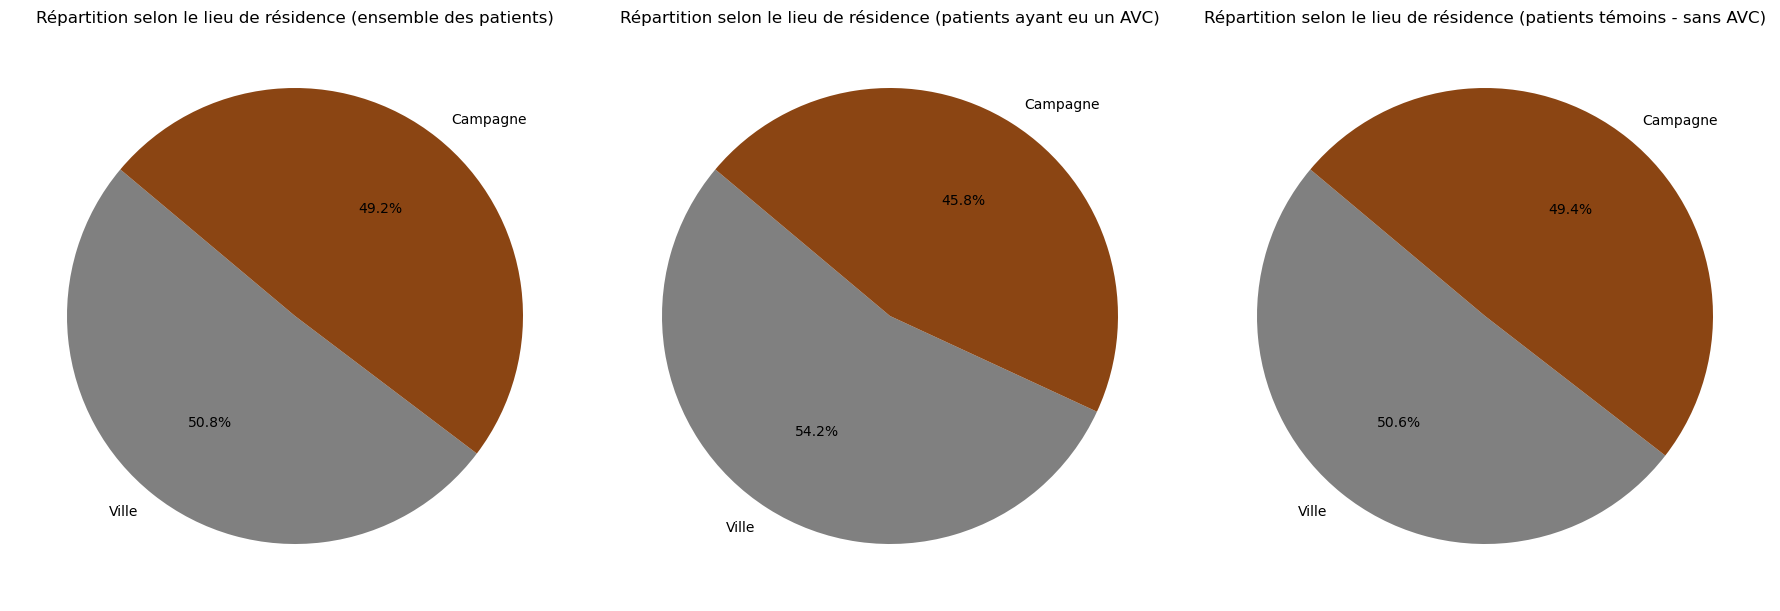

In [16]:
# Données pour le premier camembert (ensemble des patients)
urbains_all = (df['Residence_type'] == 'Urban').sum()
ruraux_all = (df['Residence_type'] == 'Rural').sum()
nombre_patients_all = [urbains_all, ruraux_all]
labels_all = ['Ville', 'Campagne']
colors_all = ['grey', '#8B4513']

# Données pour le deuxième camembert (patients ayant eu un AVC)
urbains_avc = (df_patient_avc['Residence_type'] == 'Urban').sum()
ruraux_avc = (df_patient_avc['Residence_type'] == 'Rural').sum()
nombre_patients_avc = [urbains_avc, ruraux_avc]
labels_avc = ['Ville', 'Campagne']
colors_avc = ['grey', '#8B4513']

# Données pour le troisième camembert (patients témoins - sans AVC)
urbains_no_avc = (df_patient_no_avc['Residence_type'] == 'Urban').sum()
ruraux_no_avc = (df_patient_no_avc['Residence_type'] == 'Rural').sum()
nombre_patients_no_avc = [urbains_no_avc, ruraux_no_avc]
labels_no_avc = ['Ville', 'Campagne']
colors_no_avc = ['grey', '#8B4513']

# Créer le subplot avec trois camemberts
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Premier camembert : ensemble des patients
axs[0].pie(nombre_patients_all, labels=labels_all, colors=colors_all, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Répartition selon le lieu de résidence (ensemble des patients)')

# Deuxième camembert : patients ayant eu un AVC
axs[1].pie(nombre_patients_avc, labels=labels_avc, colors=colors_avc, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Répartition selon le lieu de résidence (patients ayant eu un AVC)')

# Troisième camembert : patients témoins - sans AVC
axs[2].pie(nombre_patients_no_avc, labels=labels_no_avc, colors=colors_no_avc, autopct='%1.1f%%', startangle=140)
axs[2].set_title('Répartition selon le lieu de résidence (patients témoins - sans AVC)')

# Ajuster l'espacement entre les subplots
plt.tight_layout()

# Afficher le subplot
plt.show()

Peut-être qu'habiter en ville augmenterait légèrement les chances d'AVC.

### ► Âge

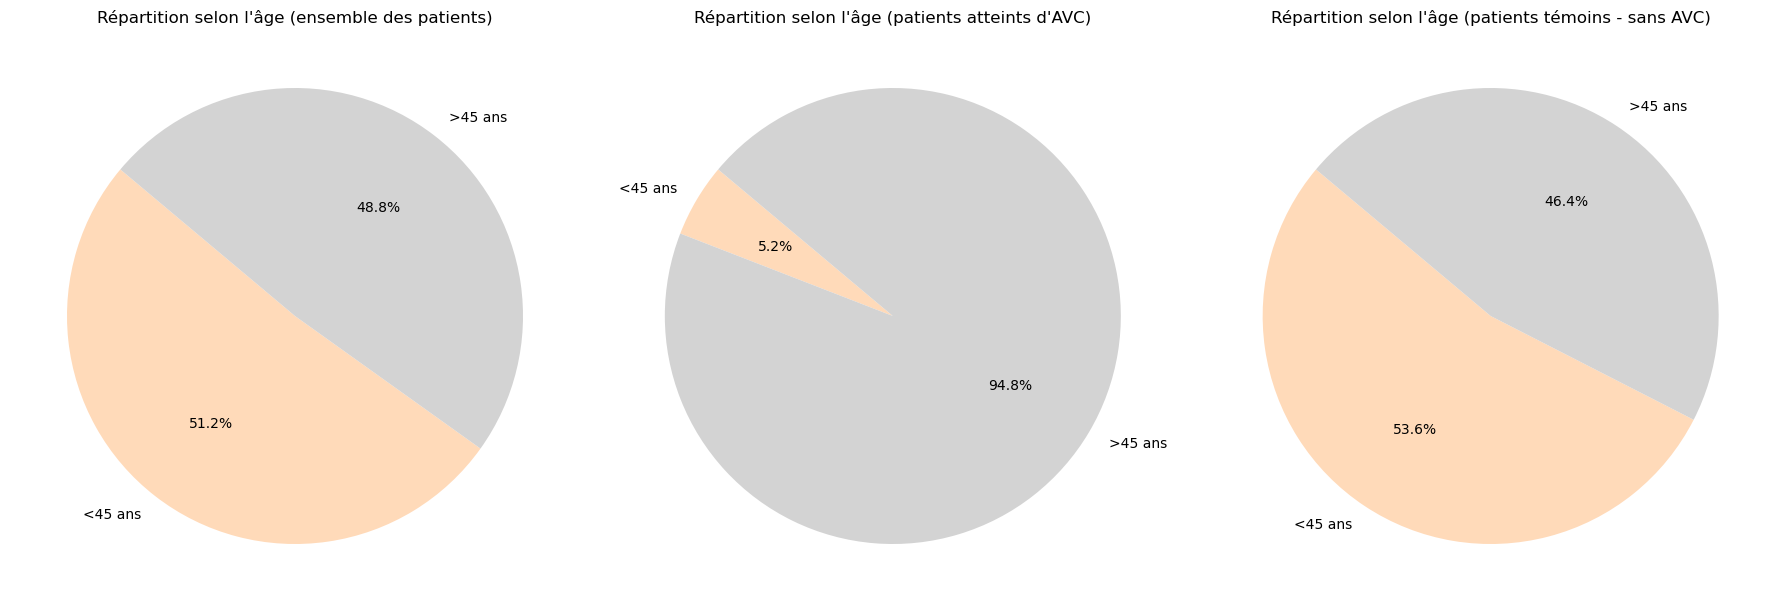

In [17]:
# Données pour le premier camembert (ensemble des patients)
jeunes_all = (df['age'] <= 45).sum()
vieux_all = (df['age'] > 45).sum()
nombre_patients_all = [jeunes_all, vieux_all]
labels_all = ['<45 ans', '>45 ans']
colors_all = ['#FFDAB9', 'lightgrey']

# Données pour le deuxième camembert (patients ayant eu un AVC)
jeunes_avc = (df_patient_avc['age'] <= 45).sum()
vieux_avc = (df_patient_avc['age'] > 45).sum()
nombre_patients_avc = [jeunes_avc, vieux_avc]
labels_avc = ['<45 ans', '>45 ans']
colors_avc = ['#FFDAB9', 'lightgrey']

# Données pour le troisième camembert (patients témoins - sans AVC)
jeunes_no_avc = (df_patient_no_avc['age'] <= 45).sum()
vieux_no_avc = (df_patient_no_avc['age'] > 45).sum()
nombre_patients_no_avc = [jeunes_no_avc, vieux_no_avc]
labels_no_avc = ['<45 ans', '>45 ans']
colors_no_avc = ['#FFDAB9', 'lightgrey']

# Créer le subplot avec trois camemberts
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Premier camembert : ensemble des patients
axs[0].pie(nombre_patients_all, labels=labels_all, colors=colors_all, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Répartition selon l\'âge (ensemble des patients)')

# Deuxième camembert : patients ayant eu un AVC
axs[1].pie(nombre_patients_avc, labels=labels_avc, colors=colors_avc, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Répartition selon l\'âge (patients atteints d\'AVC)')

# Troisième camembert : patients témoins - sans AVC
axs[2].pie(nombre_patients_no_avc, labels=labels_no_avc, colors=colors_no_avc, autopct='%1.1f%%', startangle=140)
axs[2].set_title('Répartition selon l\'âge (patients témoins - sans AVC)')

# Ajuster l'espacement entre les subplots
plt.tight_layout()

# Afficher le subplot
plt.show()

L'âge a une forte incidence sur les chances d'avoir un AVC.

### ► Hypertension

In [18]:
tension_no_avc = (df_patient_no_avc['hypertension'] == 1).sum()
tension_avc = (df_patient_avc['hypertension'] == 1).sum()
print(f"Les patients faisant de l'hypertension représentent {round(100*(tension_no_avc/df_patient_no_avc.shape[0]))}% chez les témoins et {round(100*(tension_avc/df_patient_avc.shape[0]))}% chez les atteints.")

Les patients faisant de l'hypertension représentent 9% chez les témoins et 27% chez les atteints.


À priori, l'hypertension pourrait augmenter les chances d'AVC.

### ► Maladie cardiaque

In [19]:
cardio_no_avc = (df_patient_no_avc['heart_disease'] == 1).sum()
cardio_avc = (df_patient_avc['heart_disease'] == 1).sum()
print(f"Les patients ayant des problèmes cardiaques représentent {round(100*(cardio_no_avc/df_patient_no_avc.shape[0]))}% chez les témoins et {round(100*(cardio_avc/df_patient_avc.shape[0]))}% chez les atteints.")

Les patients ayant des problèmes cardiaques représentent 5% chez les témoins et 19% chez les atteints.


Idem pour les maladies cardiaques.

### ► Incidence du mariage

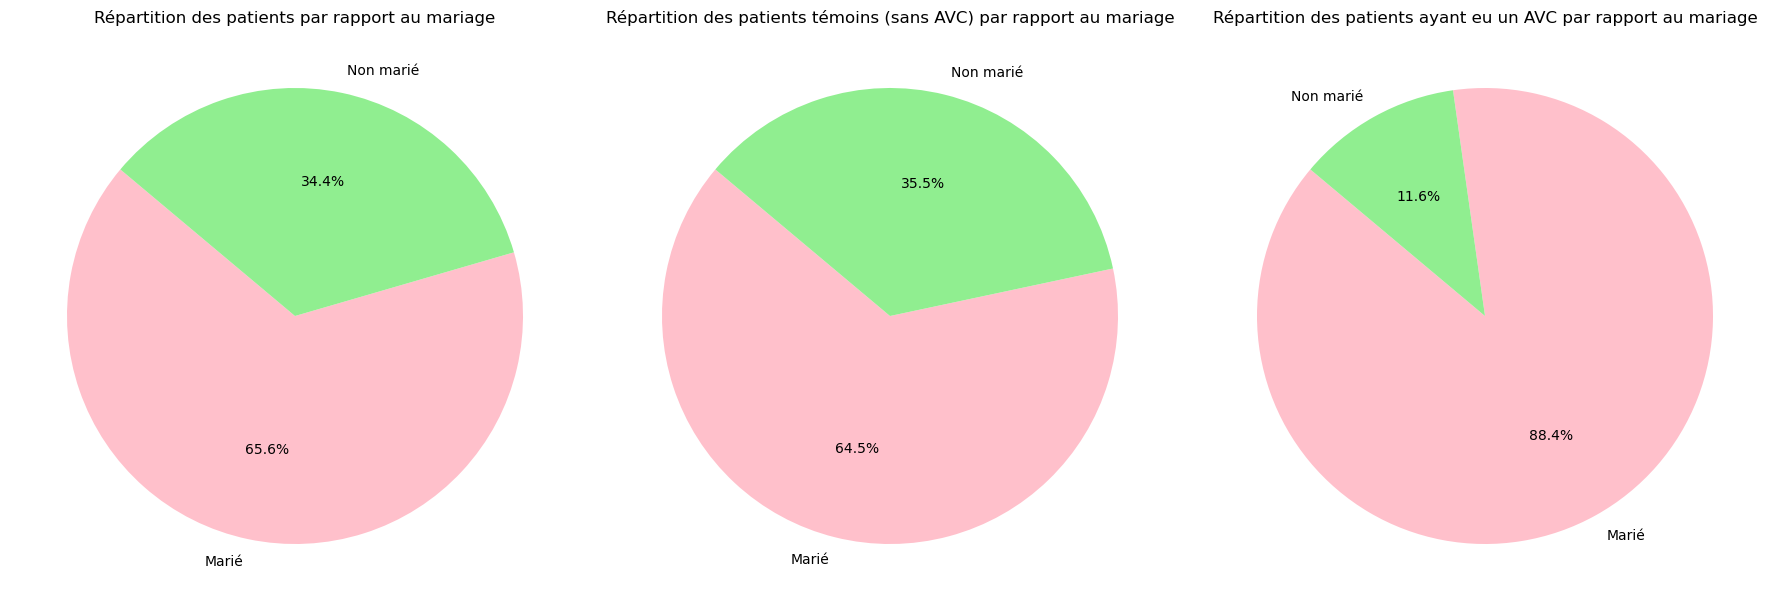

In [20]:
# Données pour le premier camembert (ensemble des patients)
wedding_all = (df['ever_married'] == 'Yes').sum()
no_wedding_all = (df['ever_married'] == 'No').sum()
nombre_patients_all = [wedding_all, no_wedding_all]
labels_all = ['Marié', 'Non marié']
colors_all = ['#FFC0CB', 'lightgreen']

# Données pour le deuxième camembert (patients témoins - sans AVC)
wedding_no_avc = (df_patient_no_avc['ever_married'] == 'Yes').sum()
no_wedding_no_avc = (df_patient_no_avc['ever_married'] == 'No').sum()
nombre_patients_no_avc = [wedding_no_avc, no_wedding_no_avc]
labels_no_avc = ['Marié', 'Non marié']
colors_no_avc = ['#FFC0CB', 'lightgreen']

# Données pour le troisième camembert (patients ayant eu un AVC)
wedding_avc = (df_patient_avc['ever_married'] == 'Yes').sum()
no_wedding_avc = (df_patient_avc['ever_married'] == 'No').sum()
nombre_patients_avc = [wedding_avc, no_wedding_avc]
labels_avc = ['Marié', 'Non marié']
colors_avc = ['#FFC0CB', 'lightgreen']

# Créer le subplot avec trois camemberts
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Premier camembert : ensemble des patients
axs[0].pie(nombre_patients_all, labels=labels_all, colors=colors_all, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Répartition des patients par rapport au mariage')

# Deuxième camembert : patients témoins - sans AVC
axs[1].pie(nombre_patients_no_avc, labels=labels_no_avc, colors=colors_no_avc, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Répartition des patients témoins (sans AVC) par rapport au mariage')

# Troisième camembert : patients ayant eu un AVC
axs[2].pie(nombre_patients_avc, labels=labels_avc, colors=colors_avc, autopct='%1.1f%%', startangle=140)
axs[2].set_title('Répartition des patients ayant eu un AVC par rapport au mariage')

# Ajuster l'espacement entre les subplots
plt.tight_layout()

# Afficher le subplot
plt.show()

Peut-être le mariage augmenterait les risques d'avoir un AVC.

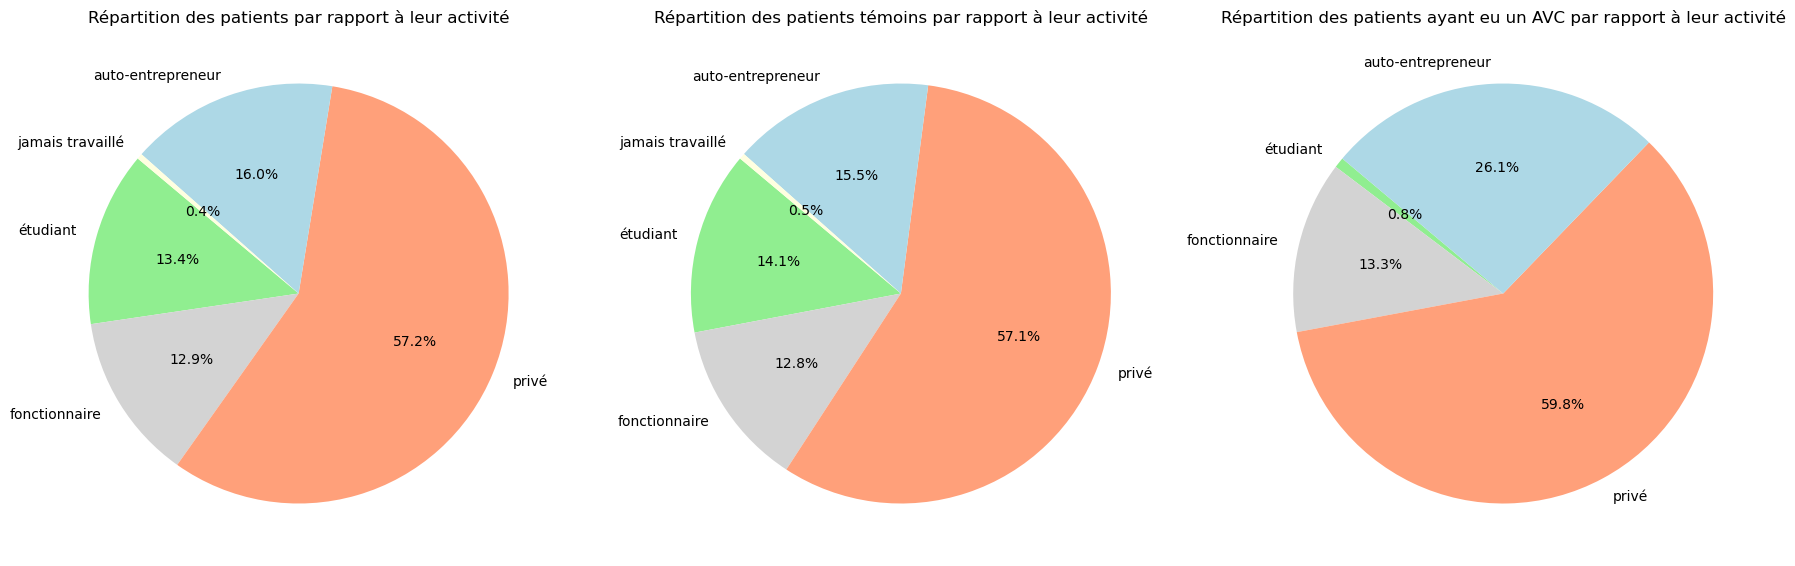

In [21]:
# Données pour le premier camembert (ensemble des patients)
work1_all = (df['work_type'] == 'children').sum()
work2_all = (df['work_type'] == 'Govt_job').sum()
work3_all = (df['work_type'] == 'Private').sum()
work4_all = (df['work_type'] == 'Self-employed').sum()
work5_all = (df['work_type'] == 'Never_worked').sum()
nombre_patients_all = [work1_all, work2_all, work3_all, work4_all, work5_all]
labels_all = ['étudiant', 'fonctionnaire','privé','auto-entrepreneur','jamais travaillé']
colors_all = ['lightgreen', 'lightgrey','#FFA07A','lightblue','lightyellow']

# Données pour le deuxième camembert (patients témoins - sans AVC)
work1_no_avc = (df_patient_no_avc['work_type'] == 'children').sum()
work2_no_avc = (df_patient_no_avc['work_type'] == 'Govt_job').sum()
work3_no_avc = (df_patient_no_avc['work_type'] == 'Private').sum()
work4_no_avc = (df_patient_no_avc['work_type'] == 'Self-employed').sum()
work5_no_avc = (df_patient_no_avc['work_type'] == 'Never_worked').sum()
nombre_patients_no_avc = [work1_no_avc, work2_no_avc, work3_no_avc, work4_no_avc, work5_no_avc]
labels_no_avc = ['étudiant', 'fonctionnaire','privé','auto-entrepreneur','jamais travaillé']
colors_no_avc = ['lightgreen', 'lightgrey','#FFA07A','lightblue','lightyellow']

# Données pour le troisième camembert (patients ayant eu un AVC)
work1_avc = (df_patient_avc['work_type'] == 'children').sum()
work2_avc = (df_patient_avc['work_type'] == 'Govt_job').sum()
work3_avc = (df_patient_avc['work_type'] == 'Private').sum()
work4_avc = (df_patient_avc['work_type'] == 'Self-employed').sum()
nombre_patients_avc = [work1_avc, work2_avc, work3_avc, work4_avc]
labels_avc = ['étudiant', 'fonctionnaire','privé','auto-entrepreneur']
colors_avc = ['lightgreen', 'lightgrey','#FFA07A','lightblue']

# Créer le subplot avec trois camemberts
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Premier camembert : ensemble des patients
axs[0].pie(nombre_patients_all, labels=labels_all, colors=colors_all, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Répartition des patients par rapport à leur activité')

# Deuxième camembert : patients témoins - sans AVC
axs[1].pie(nombre_patients_no_avc, labels=labels_no_avc, colors=colors_no_avc, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Répartition des patients témoins par rapport à leur activité')

# Troisième camembert : patients ayant eu un AVC
axs[2].pie(nombre_patients_avc, labels=labels_avc, colors=colors_avc, autopct='%1.1f%%', startangle=140)
axs[2].set_title('Répartition des patients ayant eu un AVC par rapport à leur activité')

# Ajuster l'espacement entre les subplots
plt.tight_layout()

# Afficher le subplot
plt.show()

Les auto-entrepreneurs ont peut-être plus de chances d'AVC.

#### ML feature unique

Régression logistique

Ce modèle est adapté pour prédire une variable de type binaire. C'est parfait car on veut prédire la variable 'stroke' qui est binaire. En ce qui concerne les prédicteurs, ils nous faut des variables au format numérique. Pour les autres, soit on ne les considère pas, soit on peut utiliser un encodage pour les transformer au format numérique.
Dans ce contexte médical, on favorisera un haut rappel au détriment de la précision, car on préferera prédire des faux positifs que des faux négatifs

In [22]:
# Sélectionner les features et la cible
X = df[['age']]  # Remarque : Utilisation de double crochets pour sélectionner une colonne et obtenir un DataFrame

y = df['stroke']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer le modèle de régression logistique
model = LogisticRegression()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_hat_proba_1 = model.predict_proba(X_test)[:,1]

y_pred_03 = [ 0 if value < 0.3 else 1 for value in y_hat_proba_1 ] # seuil de classification à 0.3
y_pred_07 = [ 0 if value < 0.7 else 1 for value in y_hat_proba_1 ] # seuil de classification à 0.7

# Afficher la matrice de confusion
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))

# Afficher le rapport de classification avec gestion des cas de division par zéro
print("\nRapport de classification :\n", classification_report(y_test, y_pred, zero_division=1))


# Afficher la précision
print("\nExactitude du modèle :", accuracy_score(y_test, y_pred))
print("\nPrécision du modèle :", precision_score(y_test, y_pred))
print("\nRappel du modèle :", recall_score(y_test, y_pred))

fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_hat_proba_1)


Matrice de confusion :
 [[960   0]
 [ 62   0]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       1.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.97      0.50      0.48      1022
weighted avg       0.94      0.94      0.91      1022


Exactitude du modèle : 0.9393346379647749

Précision du modèle : 0.0

Rappel du modèle : 0.0


C:\Users\St-Jean\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
partie_a_dupli = df.loc[df['stroke'] == 1,:]
df_surechant = df.copy()
for _ in range(19):
    df_surechant = pd.concat([df_surechant,partie_a_dupli], ignore_index=True)

In [24]:
# Sélectionner les features et la cible
X = df_surechant[['age']]  # Remarque : Utilisation de double crochets pour sélectionner une colonne et obtenir un DataFrame
y = df_surechant['stroke']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

# Créer le modèle de régression logistique
model = LogisticRegression()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_hat_proba_2 = model.predict_proba(X_test)[:,1]

y_pred_03 = [ 0 if value < 0.3 else 1 for value in y_hat_proba_2 ] # seuil de classification à 0.3
y_pred_07 = [ 0 if value < 0.7 else 1 for value in y_hat_proba_2 ] # seuil de classification à 0.7

# Afficher la matrice de confusion
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_03))

# Afficher le rapport de classification avec gestion des cas de division par zéro
print("\nRapport de classification :\n", classification_report(y_test, y_pred_03, zero_division=1))


# Afficher la précision
print("\nExactitude du modèle :", accuracy_score(y_test, y_pred_03))
print("\nPrécision du modèle :", precision_score(y_test, y_pred_03))
print("\nRappel du modèle :", recall_score(y_test, y_pred_03))

fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_hat_proba_2)

Matrice de confusion :
 [[2137 2257]
 [ 153 4310]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.93      0.49      0.64      4394
           1       0.66      0.97      0.78      4463

    accuracy                           0.73      8857
   macro avg       0.79      0.73      0.71      8857
weighted avg       0.79      0.73      0.71      8857


Exactitude du modèle : 0.7278988370780174

Précision du modèle : 0.6563118623420131

Rappel du modèle : 0.9657181268205243


In [25]:
df_sousechant = df.iloc[:((df['stroke'] == 1).sum()*2)]
# Sélectionner les features et la cible
X = df_sousechant[['age']]  # Remarque : Utilisation de double crochets pour sélectionner une colonne et obtenir un DataFrame
y = df_sousechant['stroke']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Créer le modèle de régression logistique
model = LogisticRegression()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_hat_proba_3 = model.predict_proba(X_test)[:,1]

y_pred_03 = [ 0 if value < 0.3 else 1 for value in y_hat_proba_3 ] # seuil de classification à 0.3
y_pred_07 = [ 0 if value < 0.7 else 1 for value in y_hat_proba_3 ] # seuil de classification à 0.7

# Afficher la matrice de confusion
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_03))

# Afficher le rapport de classification avec gestion des cas de division par zéro
print("\nRapport de classification :\n", classification_report(y_test, y_pred_03, zero_division=1))


# Afficher la précision
print("\nExactitude du modèle :", accuracy_score(y_test, y_pred_03))
print("\nPrécision du modèle :", precision_score(y_test, y_pred_03))
print("\nRappel du modèle :", recall_score(y_test, y_pred_03))

fpr_3, tpr_3, thresholds_3 = roc_curve(y_test, y_hat_proba_3)

Matrice de confusion :
 [[38 34]
 [ 8 70]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.83      0.53      0.64        72
           1       0.67      0.90      0.77        78

    accuracy                           0.72       150
   macro avg       0.75      0.71      0.71       150
weighted avg       0.75      0.72      0.71       150


Exactitude du modèle : 0.72

Précision du modèle : 0.6730769230769231

Rappel du modèle : 0.8974358974358975


[[VN  FN] [FP  VP]] Format matrice de confusion de scikit-learn


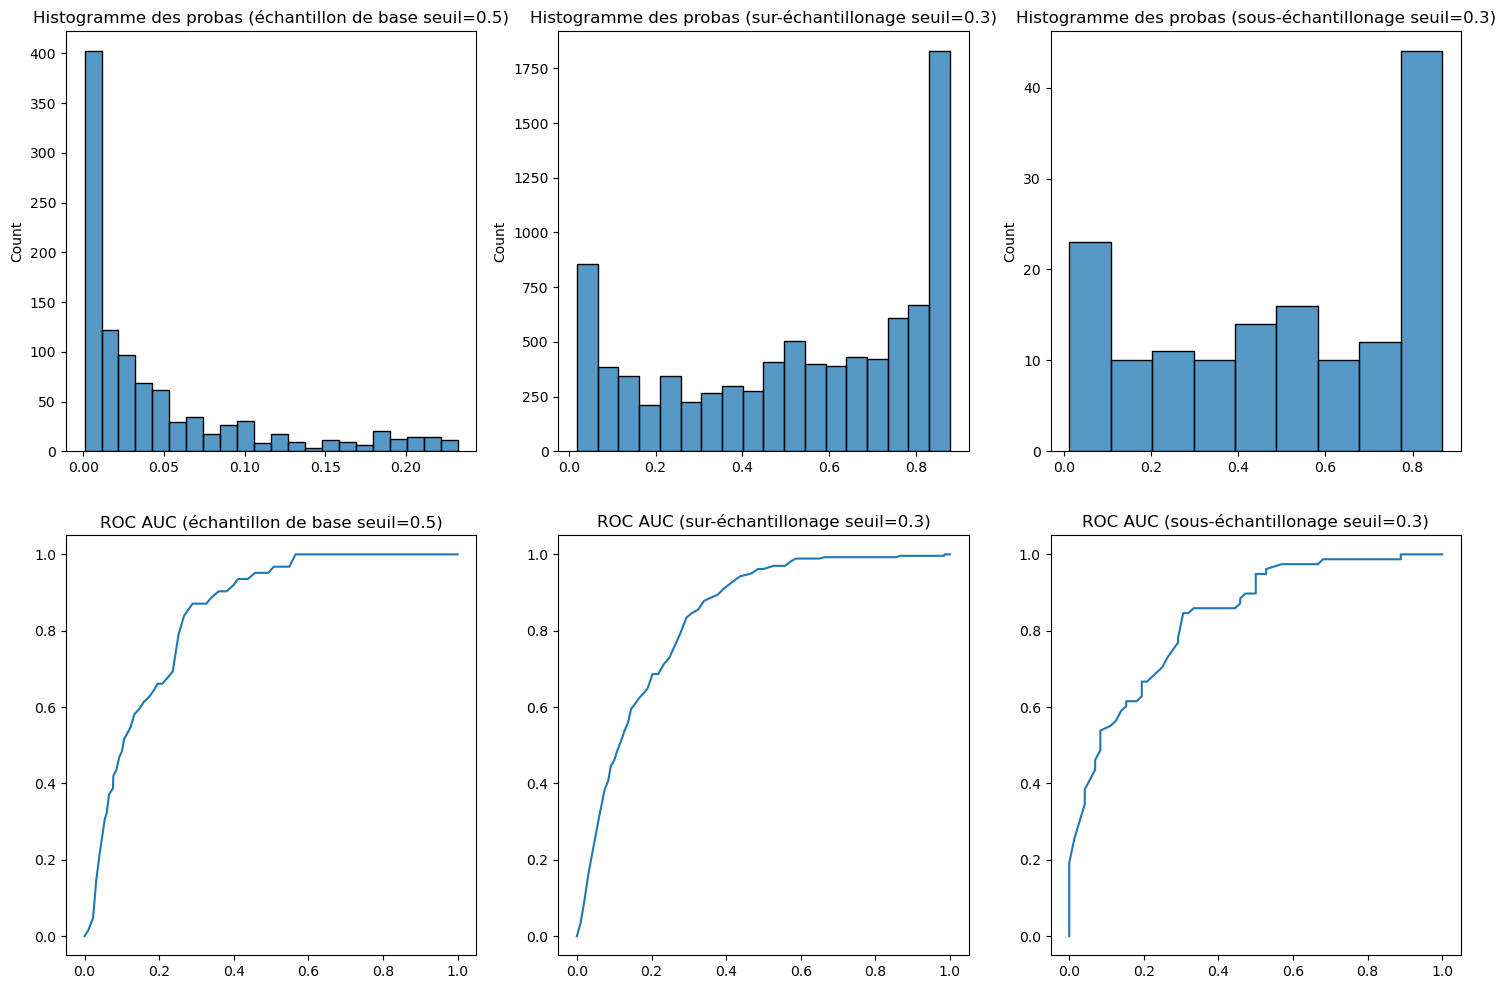

In [26]:
fig, axs = plt.subplots(2,3,figsize=(18,12))

sns.histplot (y_hat_proba_1, ax=axs [0, 0])
axs[0, 0].set_title('Histogramme des probas (échantillon de base seuil=0.5)')

sns.histplot(y_hat_proba_2, ax=axs[0, 1])
axs[0, 1].set_title('Histogramme des probas (sur-échantillonage seuil=0.3)')

sns.histplot(y_hat_proba_3, ax=axs [0, 2])
axs [0, 2].set_title('Histogramme des probas (sous-échantillonage seuil=0.3)')

axs [1, 0].plot(fpr_1, tpr_1)
axs [1, 0]. set_title('ROC AUC (échantillon de base seuil=0.5)')

axs [1, 1].plot(fpr_2, tpr_2)
axs[1, 1].set_title('ROC AUC (sur-échantillonage seuil=0.3)')

axs[1, 2].plot(fpr_3, tpr_3)
axs[1, 2].set_title('ROC AUC (sous-échantillonage seuil=0.3)')

plt.show()


Le modèle randomForest est plus flexible que la régression logistique en terme de prédicteurs, il accepte les variables numériques et catégorielles. Ce modèle prédit aussi des variables cibles de type binaire.

Random forest

In [27]:
X = df[['age']]
X = pd.get_dummies(X)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)  # Nombre d'arbres = 100
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_hat_proba_1 = model.predict_proba(X_test)[:,1]

y_pred_03 = [ 0 if value < 0.3 else 1 for value in y_hat_proba_1 ] # seuil de classification à 0.3
y_pred_07 = [ 0 if value < 0.7 else 1 for value in y_hat_proba_1 ] # seuil de classification à 0.7

# Afficher la matrice de confusion
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))

# Afficher le rapport de classification avec gestion des cas de division par zéro
print("\nRapport de classification :\n", classification_report(y_test, y_pred, zero_division=1))


# Afficher la précision
print("\nExactitude du modèle :", accuracy_score(y_test, y_pred))
print("\nPrécision du modèle :", precision_score(y_test, y_pred))
print("\nRappel du modèle :", recall_score(y_test, y_pred))

fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_hat_proba_1)




Matrice de confusion :
 [[960   0]
 [ 62   0]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       1.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.97      0.50      0.48      1022
weighted avg       0.94      0.94      0.91      1022


Exactitude du modèle : 0.9393346379647749

Précision du modèle : 0.0

Rappel du modèle : 0.0


C:\Users\St-Jean\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
X = df_surechant[['age']]
X = pd.get_dummies(X)
y = df_surechant['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)  # Nombre d'arbres = 100
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_hat_proba_2 = model.predict_proba(X_test)[:,1]

y_pred_03 = [ 0 if value < 0.3 else 1 for value in y_hat_proba_2 ] # seuil de classification à 0.3
y_pred_07 = [ 0 if value < 0.7 else 1 for value in y_hat_proba_2 ] # seuil de classification à 0.7

# Afficher la matrice de confusion
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))

# Afficher le rapport de classification avec gestion des cas de division par zéro
print("\nRapport de classification :\n", classification_report(y_test, y_pred, zero_division=1))


# Afficher la précision
print("\nExactitude du modèle :", accuracy_score(y_test, y_pred))
print("\nPrécision du modèle :", precision_score(y_test, y_pred))
print("\nRappel du modèle :", recall_score(y_test, y_pred))


fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_hat_proba_2)




Matrice de confusion :
 [[ 996  474]
 [ 187 1296]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.84      0.68      0.75      1470
           1       0.73      0.87      0.80      1483

    accuracy                           0.78      2953
   macro avg       0.79      0.78      0.77      2953
weighted avg       0.79      0.78      0.77      2953


Exactitude du modèle : 0.7761598374534372

Précision du modèle : 0.7322033898305085

Rappel du modèle : 0.8739042481456507


In [29]:
X = df_sousechant[['age']]
X = pd.get_dummies(X)
y = df_sousechant['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)  # Nombre d'arbres = 100
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_hat_proba_3 = model.predict_proba(X_test)[:,1]

y_pred_03 = [ 0 if value < 0.3 else 1 for value in y_hat_proba_3 ] # seuil de classification à 0.3
y_pred_07 = [ 0 if value < 0.7 else 1 for value in y_hat_proba_3 ] # seuil de classification à 0.7

# Afficher la matrice de confusion
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_03))

# Afficher le rapport de classification avec gestion des cas de division par zéro
print("\nRapport de classification :\n", classification_report(y_test, y_pred_03, zero_division=1))


# Afficher la précision
print("\nExactitude du modèle :", accuracy_score(y_test, y_pred_03))
print("\nPrécision du modèle :", precision_score(y_test, y_pred_03))
print("\nRappel du modèle :", recall_score(y_test, y_pred_03))

fpr_3, tpr_3, thresholds_3 = roc_curve(y_test, y_hat_proba_3)



Matrice de confusion :
 [[39 33]
 [ 9 69]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.81      0.54      0.65        72
           1       0.68      0.88      0.77        78

    accuracy                           0.72       150
   macro avg       0.74      0.71      0.71       150
weighted avg       0.74      0.72      0.71       150


Exactitude du modèle : 0.72

Précision du modèle : 0.6764705882352942

Rappel du modèle : 0.8846153846153846


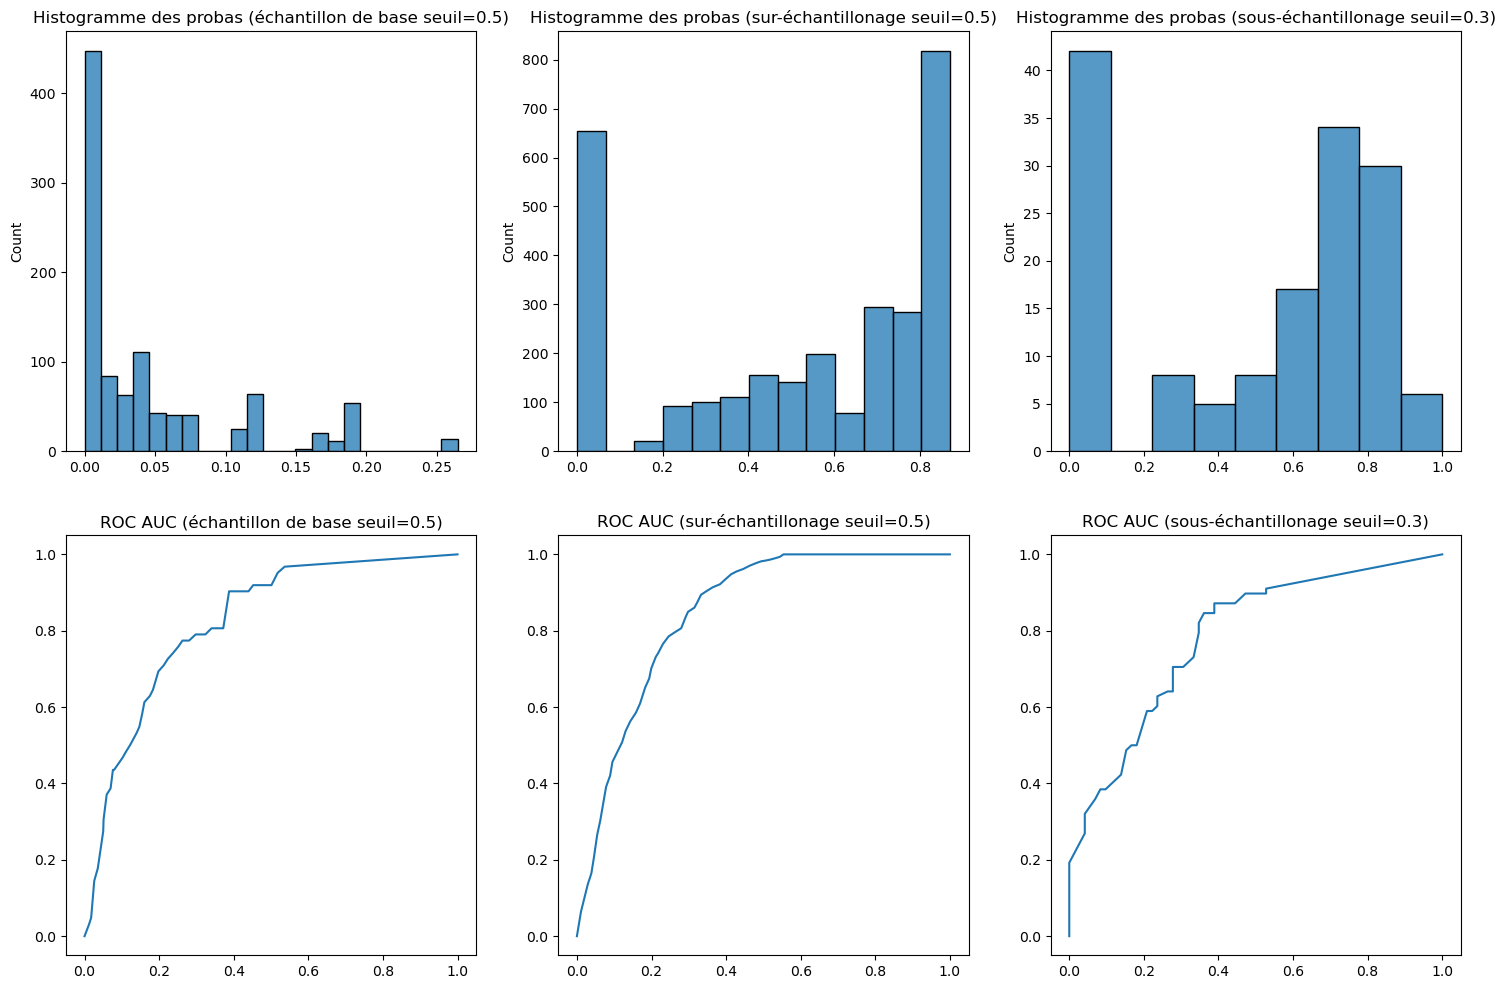

In [30]:
fig, axs = plt.subplots(2,3,figsize=(18,12))

sns.histplot (y_hat_proba_1, ax=axs [0, 0])
axs[0, 0].set_title('Histogramme des probas (échantillon de base seuil=0.5)')

sns.histplot(y_hat_proba_2, ax=axs[0, 1])
axs[0, 1].set_title('Histogramme des probas (sur-échantillonage seuil=0.5)')

sns.histplot(y_hat_proba_3, ax=axs [0, 2])
axs [0, 2].set_title('Histogramme des probas (sous-échantillonage seuil=0.3)')

axs [1, 0].plot(fpr_1, tpr_1)
axs [1, 0]. set_title('ROC AUC (échantillon de base seuil=0.5)')

axs [1, 1].plot(fpr_2, tpr_2)
axs[1, 1].set_title('ROC AUC (sur-échantillonage seuil=0.5)')

axs[1, 2].plot(fpr_3, tpr_3)
axs[1, 2].set_title('ROC AUC (sous-échantillonage seuil=0.3)')

plt.show()


Gradient boosting classifier

In [44]:
# Sélectionner les features et la cible
X = df[['age']]

y = df['stroke']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer le modèle de régression logistique
model = GradientBoostingClassifier()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_hat_proba_1 = model.predict_proba(X_test)[:,1]

y_pred_03 = [ 0 if value < 0.3 else 1 for value in y_hat_proba_1 ] # seuil de classification à 0.3
y_pred_07 = [ 0 if value < 0.7 else 1 for value in y_hat_proba_1 ] # seuil de classification à 0.7

# Afficher la matrice de confusion
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))

# Afficher le rapport de classification avec gestion des cas de division par zéro
print("\nRapport de classification :\n", classification_report(y_test, y_pred, zero_division=1))


# Afficher la précision
print("\nExactitude du modèle :", accuracy_score(y_test, y_pred))
print("\nPrécision du modèle :", precision_score(y_test, y_pred))
print("\nRappel du modèle :", recall_score(y_test, y_pred))

fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_hat_proba_1)


Matrice de confusion :
 [[960   0]
 [ 62   0]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       1.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.97      0.50      0.48      1022
weighted avg       0.94      0.94      0.91      1022


Exactitude du modèle : 0.9393346379647749

Précision du modèle : 0.0

Rappel du modèle : 0.0


C:\Users\St-Jean\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
X = df_surechant[['age']]

y = df_surechant['stroke']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

# Créer le modèle de régression logistique
model = GradientBoostingClassifier()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_hat_proba_2 = model.predict_proba(X_test)[:,1]

y_pred_03 = [ 0 if value < 0.3 else 1 for value in y_hat_proba_2 ] # seuil de classification à 0.3
y_pred_07 = [ 0 if value < 0.7 else 1 for value in y_hat_proba_2 ] # seuil de classification à 0.7

# Afficher la matrice de confusion
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_03))

# Afficher le rapport de classification avec gestion des cas de division par zéro
print("\nRapport de classification :\n", classification_report(y_test, y_pred_03, zero_division=1))


# Afficher la précision
print("\nExactitude du modèle :", accuracy_score(y_test, y_pred_03))
print("\nPrécision du modèle :", precision_score(y_test, y_pred_03))
print("\nRappel du modèle :", recall_score(y_test, y_pred_03))

fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_hat_proba_2)

Matrice de confusion :
 [[2152 2242]
 [  75 4388]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      0.49      0.65      4394
           1       0.66      0.98      0.79      4463

    accuracy                           0.74      8857
   macro avg       0.81      0.74      0.72      8857
weighted avg       0.81      0.74      0.72      8857


Exactitude du modèle : 0.7383990064355876

Précision du modèle : 0.6618401206636501

Rappel du modèle : 0.9831951602061394


In [46]:
df_sousechant = df.iloc[:((df['stroke'] == 1).sum()*2)]
X = df_sousechant[['age']]

y = df_sousechant['stroke']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Créer le modèle de régression logistique
model = GradientBoostingClassifier()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_hat_proba_3 = model.predict_proba(X_test)[:,1]

y_pred_03 = [ 0 if value < 0.3 else 1 for value in y_hat_proba_3 ] # seuil de classification à 0.3
y_pred_07 = [ 0 if value < 0.7 else 1 for value in y_hat_proba_3 ] # seuil de classification à 0.7

# Afficher la matrice de confusion
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_03))

# Afficher le rapport de classification avec gestion des cas de division par zéro
print("\nRapport de classification :\n", classification_report(y_test, y_pred_03, zero_division=1))


# Afficher la précision
print("\nExactitude du modèle :", accuracy_score(y_test, y_pred_03))
print("\nPrécision du modèle :", precision_score(y_test, y_pred_03))
print("\nRappel du modèle :", recall_score(y_test, y_pred_03))

fpr_3, tpr_3, thresholds_3 = roc_curve(y_test, y_hat_proba_3)

Matrice de confusion :
 [[38 34]
 [ 8 70]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.83      0.53      0.64        72
           1       0.67      0.90      0.77        78

    accuracy                           0.72       150
   macro avg       0.75      0.71      0.71       150
weighted avg       0.75      0.72      0.71       150


Exactitude du modèle : 0.72

Précision du modèle : 0.6730769230769231

Rappel du modèle : 0.8974358974358975


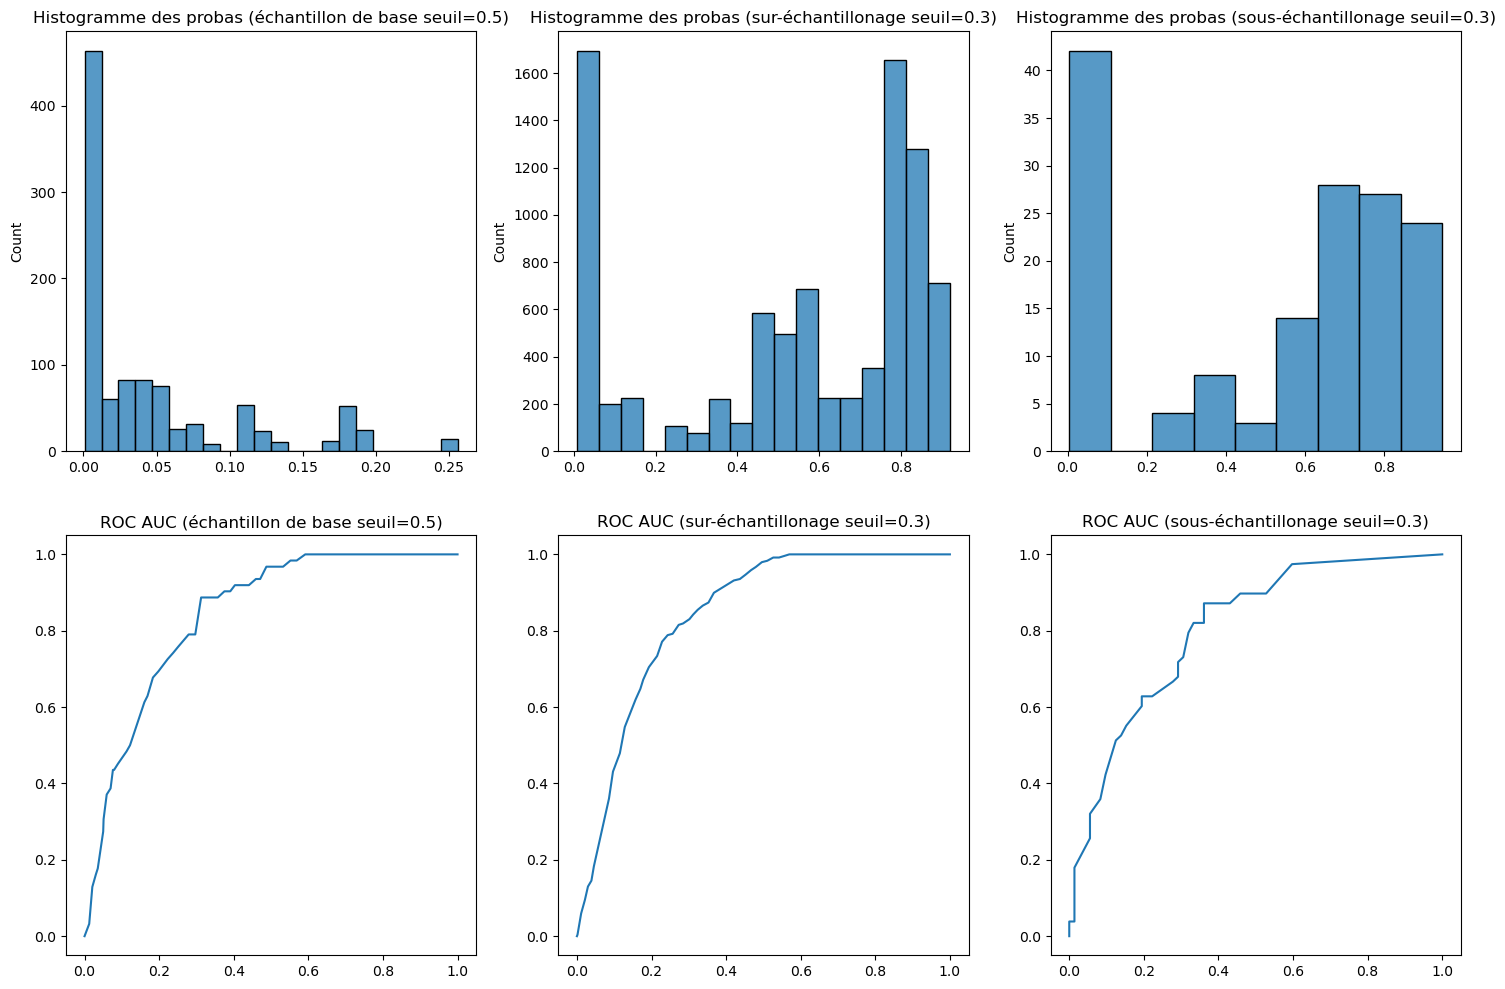

In [47]:
fig, axs = plt.subplots(2,3,figsize=(18,12))

sns.histplot (y_hat_proba_1, ax=axs [0, 0])
axs[0, 0].set_title('Histogramme des probas (échantillon de base seuil=0.5)')

sns.histplot(y_hat_proba_2, ax=axs[0, 1])
axs[0, 1].set_title('Histogramme des probas (sur-échantillonage seuil=0.3)')

sns.histplot(y_hat_proba_3, ax=axs [0, 2])
axs [0, 2].set_title('Histogramme des probas (sous-échantillonage seuil=0.3)')

axs [1, 0].plot(fpr_1, tpr_1)
axs [1, 0]. set_title('ROC AUC (échantillon de base seuil=0.5)')

axs [1, 1].plot(fpr_2, tpr_2)
axs[1, 1].set_title('ROC AUC (sur-échantillonage seuil=0.3)')

axs[1, 2].plot(fpr_3, tpr_3)
axs[1, 2].set_title('ROC AUC (sous-échantillonage seuil=0.3)')

plt.show()


#### feature multiple

Random forest

In [31]:
X = df[['ever_married','age','Residence_type','hypertension', 'smoking_status','heart_disease','work_type', 'gender']]
X = pd.get_dummies(X)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)  # Nombre d'arbres = 100
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_hat_proba_1 = model.predict_proba(X_test)[:,1]

y_pred_03 = [ 0 if value < 0.3 else 1 for value in y_hat_proba_1 ] # seuil de classification à 0.3
y_pred_07 = [ 0 if value < 0.7 else 1 for value in y_hat_proba_1 ] # seuil de classification à 0.7

# Afficher la matrice de confusion
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))

# Afficher le rapport de classification avec gestion des cas de division par zéro
print("\nRapport de classification :\n", classification_report(y_test, y_pred, zero_division=1))


# Afficher la précision
print("\nExactitude du modèle :", accuracy_score(y_test, y_pred))
print("\nPrécision du modèle :", precision_score(y_test, y_pred))
print("\nRappel du modèle :", recall_score(y_test, y_pred))

fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_hat_proba_1)




Matrice de confusion :
 [[939  21]
 [ 58   4]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       960
           1       0.16      0.06      0.09        62

    accuracy                           0.92      1022
   macro avg       0.55      0.52      0.53      1022
weighted avg       0.89      0.92      0.91      1022


Exactitude du modèle : 0.9227005870841487

Précision du modèle : 0.16

Rappel du modèle : 0.06451612903225806


In [32]:
X = df_surechant[['ever_married','age','Residence_type','hypertension', 'smoking_status','heart_disease','work_type', 'gender']]
X = pd.get_dummies(X)
y = df_surechant['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)  # Nombre d'arbres = 100
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_hat_proba_2 = model.predict_proba(X_test)[:,1]

y_pred_03 = [ 0 if value < 0.3 else 1 for value in y_hat_proba_2 ] # seuil de classification à 0.3
y_pred_07 = [ 0 if value < 0.7 else 1 for value in y_hat_proba_2 ] # seuil de classification à 0.7

# Afficher la matrice de confusion
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))

# Afficher le rapport de classification avec gestion des cas de division par zéro
print("\nRapport de classification :\n", classification_report(y_test, y_pred, zero_division=1))


# Afficher la précision
print("\nExactitude du modèle :", accuracy_score(y_test, y_pred))
print("\nPrécision du modèle :", precision_score(y_test, y_pred))
print("\nRappel du modèle :", recall_score(y_test, y_pred))


fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_hat_proba_2)




Matrice de confusion :
 [[1335  135]
 [   0 1483]]

Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.91      0.95      1470
           1       0.92      1.00      0.96      1483

    accuracy                           0.95      2953
   macro avg       0.96      0.95      0.95      2953
weighted avg       0.96      0.95      0.95      2953


Exactitude du modèle : 0.9542837792075856

Précision du modèle : 0.9165636588380717

Rappel du modèle : 1.0


In [33]:
X = df_sousechant[['ever_married','age','Residence_type','hypertension', 'smoking_status','heart_disease','work_type', 'gender']]
X = pd.get_dummies(X)
y = df_sousechant['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)  # Nombre d'arbres = 100
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_hat_proba_3 = model.predict_proba(X_test)[:,1]

y_pred_03 = [ 0 if value < 0.3 else 1 for value in y_hat_proba_3 ] # seuil de classification à 0.3
y_pred_07 = [ 0 if value < 0.7 else 1 for value in y_hat_proba_3 ] # seuil de classification à 0.7

# Afficher la matrice de confusion
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_03))

# Afficher le rapport de classification avec gestion des cas de division par zéro
print("\nRapport de classification :\n", classification_report(y_test, y_pred_03, zero_division=1))


# Afficher la précision
print("\nExactitude du modèle :", accuracy_score(y_test, y_pred_03))
print("\nPrécision du modèle :", precision_score(y_test, y_pred_03))
print("\nRappel du modèle :", recall_score(y_test, y_pred_03))

fpr_3, tpr_3, thresholds_3 = roc_curve(y_test, y_hat_proba_3)



Matrice de confusion :
 [[38 34]
 [ 9 69]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.81      0.53      0.64        72
           1       0.67      0.88      0.76        78

    accuracy                           0.71       150
   macro avg       0.74      0.71      0.70       150
weighted avg       0.74      0.71      0.70       150


Exactitude du modèle : 0.7133333333333334

Précision du modèle : 0.6699029126213593

Rappel du modèle : 0.8846153846153846


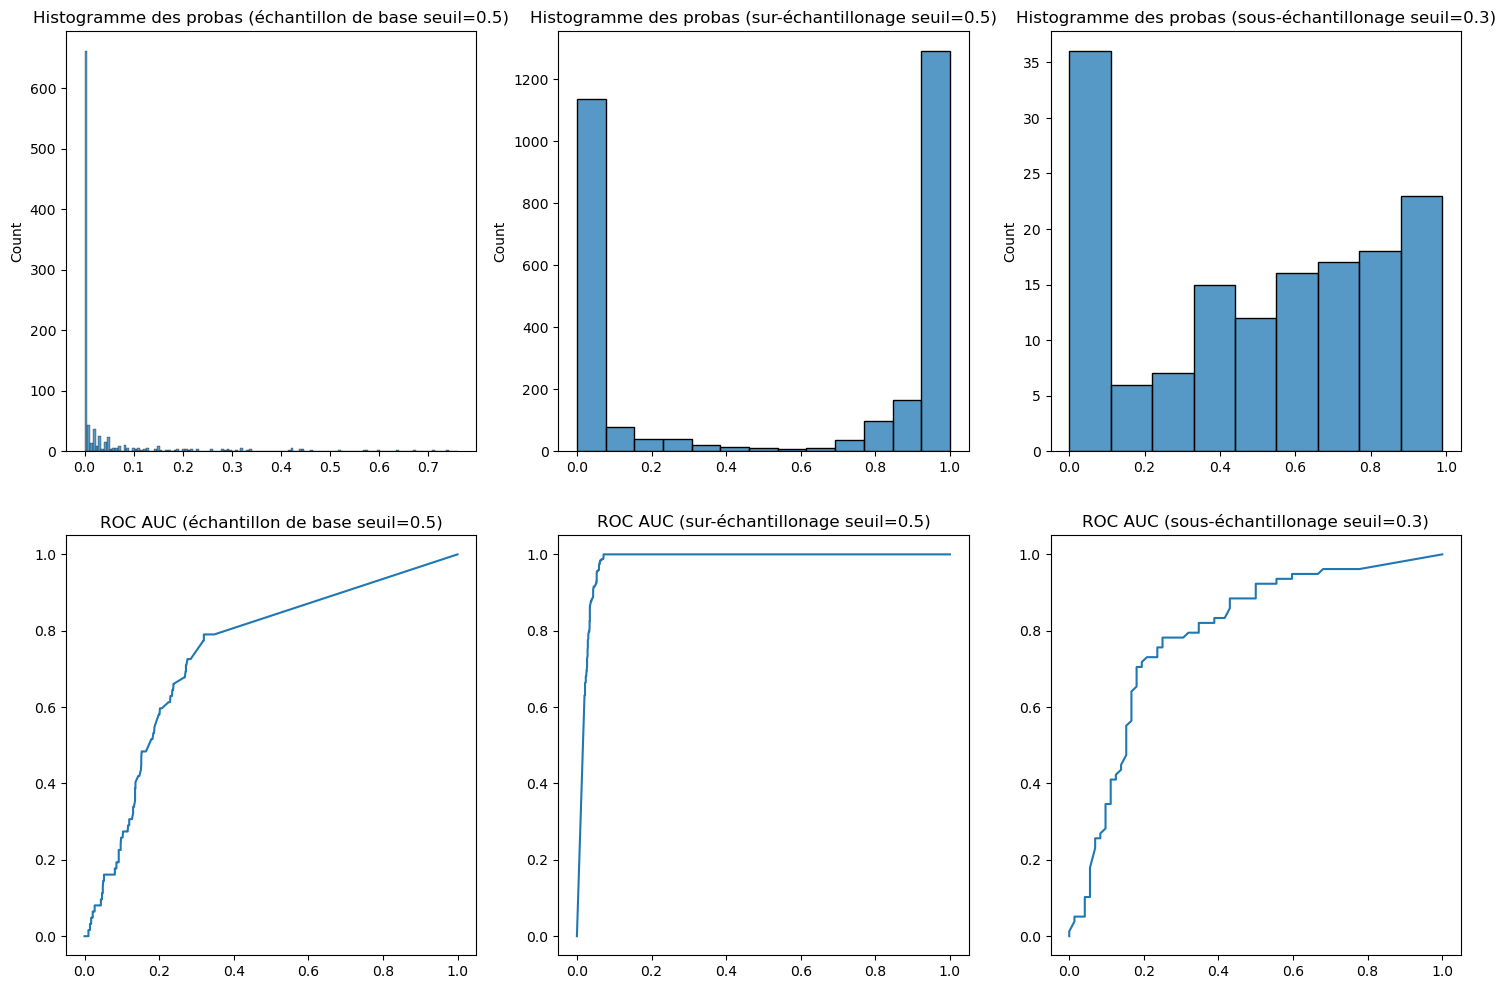

In [34]:
fig, axs = plt.subplots(2,3,figsize=(18,12))

sns.histplot (y_hat_proba_1, ax=axs [0, 0])
axs[0, 0].set_title('Histogramme des probas (échantillon de base seuil=0.5)')

sns.histplot(y_hat_proba_2, ax=axs[0, 1])
axs[0, 1].set_title('Histogramme des probas (sur-échantillonage seuil=0.5)')

sns.histplot(y_hat_proba_3, ax=axs [0, 2])
axs [0, 2].set_title('Histogramme des probas (sous-échantillonage seuil=0.3)')

axs [1, 0].plot(fpr_1, tpr_1)
axs [1, 0]. set_title('ROC AUC (échantillon de base seuil=0.5)')

axs [1, 1].plot(fpr_2, tpr_2)
axs[1, 1].set_title('ROC AUC (sur-échantillonage seuil=0.5)')

axs[1, 2].plot(fpr_3, tpr_3)
axs[1, 2].set_title('ROC AUC (sous-échantillonage seuil=0.3)')

plt.show()


Régression logistique

In [35]:
# Sélectionner les features et la cible
X = df[['ever_married','age','Residence_type','hypertension', 'smoking_status','heart_disease','work_type', 'gender']]
X = pd.get_dummies(X)
y = df['stroke']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer le modèle de régression logistique
model = LogisticRegression()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_hat_proba_1 = model.predict_proba(X_test)[:,1]

y_pred_03 = [ 0 if value < 0.3 else 1 for value in y_hat_proba_1 ] # seuil de classification à 0.3
y_pred_07 = [ 0 if value < 0.7 else 1 for value in y_hat_proba_1 ] # seuil de classification à 0.7

# Afficher la matrice de confusion
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))

# Afficher le rapport de classification avec gestion des cas de division par zéro
print("\nRapport de classification :\n", classification_report(y_test, y_pred, zero_division=1))


# Afficher la précision
print("\nExactitude du modèle :", accuracy_score(y_test, y_pred))
print("\nPrécision du modèle :", precision_score(y_test, y_pred))
print("\nRappel du modèle :", recall_score(y_test, y_pred))

fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_hat_proba_1)


Matrice de confusion :
 [[960   0]
 [ 62   0]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       1.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.97      0.50      0.48      1022
weighted avg       0.94      0.94      0.91      1022


Exactitude du modèle : 0.9393346379647749

Précision du modèle : 0.0

Rappel du modèle : 0.0


C:\Users\St-Jean\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\St-Jean\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
X = df_surechant[['ever_married','age','Residence_type','hypertension', 'smoking_status','heart_disease','work_type', 'gender']]
X = pd.get_dummies(X)
y = df_surechant['stroke']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

# Créer le modèle de régression logistique
model = LogisticRegression()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_hat_proba_2 = model.predict_proba(X_test)[:,1]

y_pred_03 = [ 0 if value < 0.3 else 1 for value in y_hat_proba_2 ] # seuil de classification à 0.3
y_pred_07 = [ 0 if value < 0.7 else 1 for value in y_hat_proba_2 ] # seuil de classification à 0.7

# Afficher la matrice de confusion
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_03))

# Afficher le rapport de classification avec gestion des cas de division par zéro
print("\nRapport de classification :\n", classification_report(y_test, y_pred_03, zero_division=1))


# Afficher la précision
print("\nExactitude du modèle :", accuracy_score(y_test, y_pred_03))
print("\nPrécision du modèle :", precision_score(y_test, y_pred_03))
print("\nRappel du modèle :", recall_score(y_test, y_pred_03))

fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_hat_proba_2)

C:\Users\St-Jean\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Matrice de confusion :
 [[2297 2097]
 [ 153 4310]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.94      0.52      0.67      4394
           1       0.67      0.97      0.79      4463

    accuracy                           0.75      8857
   macro avg       0.81      0.74      0.73      8857
weighted avg       0.80      0.75      0.73      8857


Exactitude du modèle : 0.7459636445749125

Précision du modèle : 0.6727017324800999

Rappel du modèle : 0.9657181268205243


In [37]:
df_sousechant = df.iloc[:((df['stroke'] == 1).sum()*2)]
X = df_sousechant[['ever_married','age','Residence_type','hypertension', 'smoking_status','heart_disease','work_type', 'gender']]
X = pd.get_dummies(X)  # Remarque : Utilisation de double crochets pour sélectionner une colonne et obtenir un DataFrame
y = df_sousechant['stroke']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Créer le modèle de régression logistique
model = LogisticRegression()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_hat_proba_3 = model.predict_proba(X_test)[:,1]

y_pred_03 = [ 0 if value < 0.3 else 1 for value in y_hat_proba_3 ] # seuil de classification à 0.3
y_pred_07 = [ 0 if value < 0.7 else 1 for value in y_hat_proba_3 ] # seuil de classification à 0.7

# Afficher la matrice de confusion
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_03))

# Afficher le rapport de classification avec gestion des cas de division par zéro
print("\nRapport de classification :\n", classification_report(y_test, y_pred_03, zero_division=1))


# Afficher la précision
print("\nExactitude du modèle :", accuracy_score(y_test, y_pred_03))
print("\nPrécision du modèle :", precision_score(y_test, y_pred_03))
print("\nRappel du modèle :", recall_score(y_test, y_pred_03))

fpr_3, tpr_3, thresholds_3 = roc_curve(y_test, y_hat_proba_3)

Matrice de confusion :
 [[39 33]
 [ 9 69]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.81      0.54      0.65        72
           1       0.68      0.88      0.77        78

    accuracy                           0.72       150
   macro avg       0.74      0.71      0.71       150
weighted avg       0.74      0.72      0.71       150


Exactitude du modèle : 0.72

Précision du modèle : 0.6764705882352942

Rappel du modèle : 0.8846153846153846


C:\Users\St-Jean\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


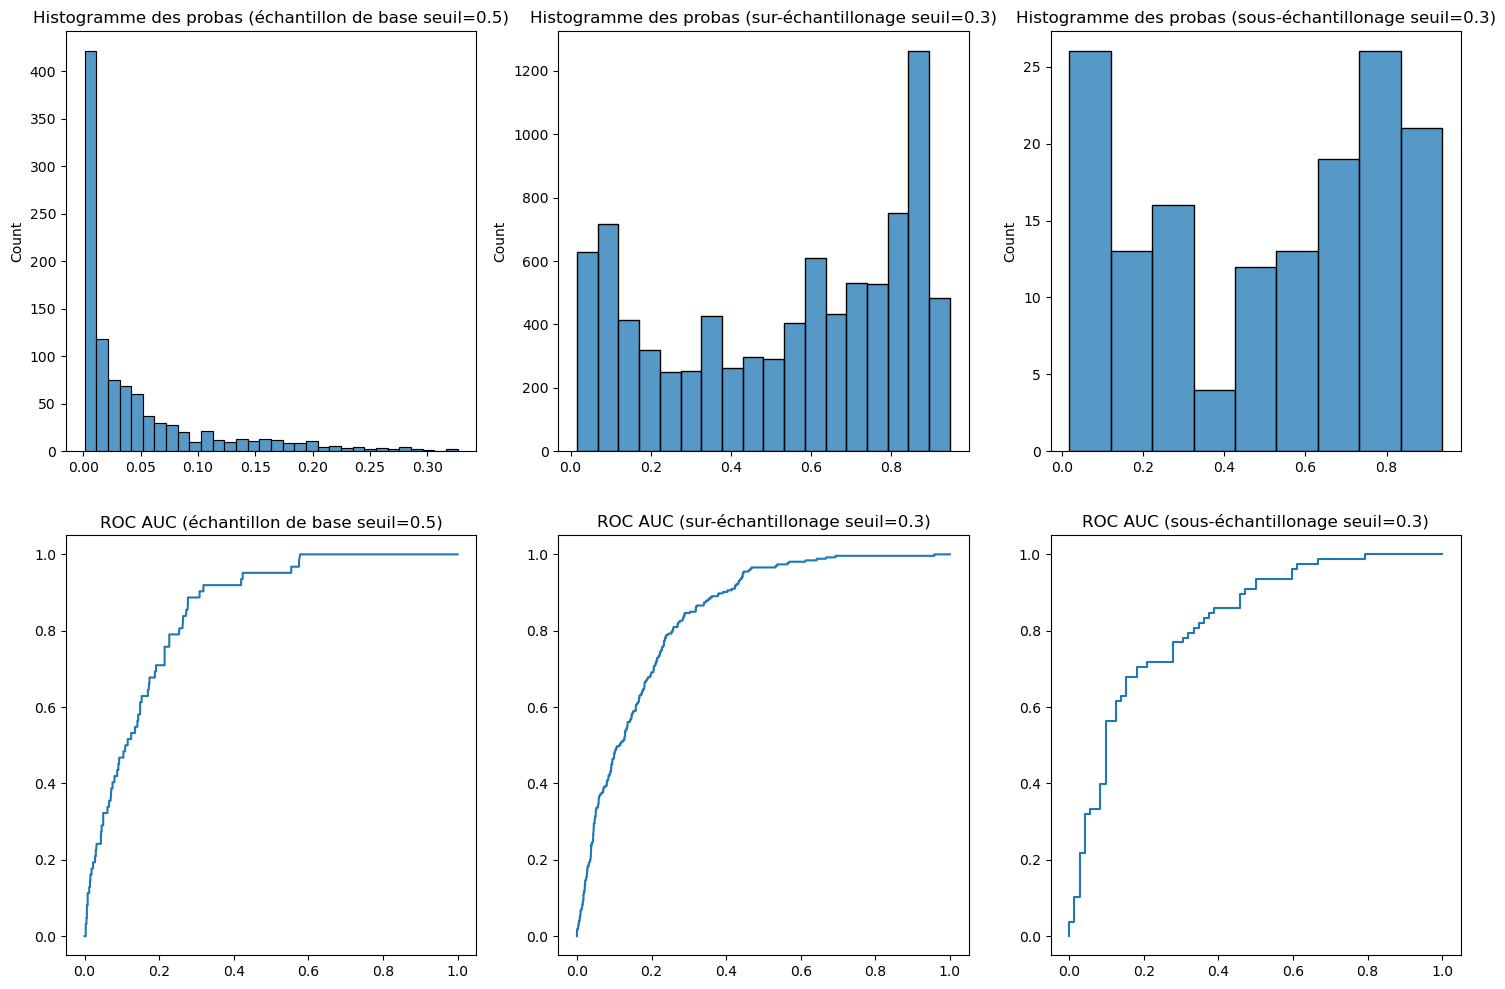

In [38]:
fig, axs = plt.subplots(2,3,figsize=(18,12))

sns.histplot (y_hat_proba_1, ax=axs [0, 0])
axs[0, 0].set_title('Histogramme des probas (échantillon de base seuil=0.5)')

sns.histplot(y_hat_proba_2, ax=axs[0, 1])
axs[0, 1].set_title('Histogramme des probas (sur-échantillonage seuil=0.3)')

sns.histplot(y_hat_proba_3, ax=axs [0, 2])
axs [0, 2].set_title('Histogramme des probas (sous-échantillonage seuil=0.3)')

axs [1, 0].plot(fpr_1, tpr_1)
axs [1, 0]. set_title('ROC AUC (échantillon de base seuil=0.5)')

axs [1, 1].plot(fpr_2, tpr_2)
axs[1, 1].set_title('ROC AUC (sur-échantillonage seuil=0.3)')

axs[1, 2].plot(fpr_3, tpr_3)
axs[1, 2].set_title('ROC AUC (sous-échantillonage seuil=0.3)')

plt.show()


Gradient boosting classifier

In [39]:
# Sélectionner les features et la cible
X = df[['ever_married','age','Residence_type','hypertension', 'smoking_status','heart_disease','work_type', 'gender']]
X = pd.get_dummies(X)
y = df['stroke']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer le modèle de régression logistique
model = GradientBoostingClassifier()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_hat_proba_1 = model.predict_proba(X_test)[:,1]

y_pred_03 = [ 0 if value < 0.3 else 1 for value in y_hat_proba_1 ] # seuil de classification à 0.3
y_pred_07 = [ 0 if value < 0.7 else 1 for value in y_hat_proba_1 ] # seuil de classification à 0.7

# Afficher la matrice de confusion
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))

# Afficher le rapport de classification avec gestion des cas de division par zéro
print("\nRapport de classification :\n", classification_report(y_test, y_pred, zero_division=1))


# Afficher la précision
print("\nExactitude du modèle :", accuracy_score(y_test, y_pred))
print("\nPrécision du modèle :", precision_score(y_test, y_pred))
print("\nRappel du modèle :", recall_score(y_test, y_pred))

fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_hat_proba_1)


Matrice de confusion :
 [[960   0]
 [ 62   0]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       1.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.97      0.50      0.48      1022
weighted avg       0.94      0.94      0.91      1022


Exactitude du modèle : 0.9393346379647749

Précision du modèle : 0.0

Rappel du modèle : 0.0


C:\Users\St-Jean\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
X = df_surechant[['ever_married','age','Residence_type','hypertension', 'smoking_status','heart_disease','work_type', 'gender']]
X = pd.get_dummies(X)
y = df_surechant['stroke']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

# Créer le modèle de régression logistique
model = GradientBoostingClassifier()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_hat_proba_2 = model.predict_proba(X_test)[:,1]

y_pred_03 = [ 0 if value < 0.3 else 1 for value in y_hat_proba_2 ] # seuil de classification à 0.3
y_pred_07 = [ 0 if value < 0.7 else 1 for value in y_hat_proba_2 ] # seuil de classification à 0.7

# Afficher la matrice de confusion
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_03))

# Afficher le rapport de classification avec gestion des cas de division par zéro
print("\nRapport de classification :\n", classification_report(y_test, y_pred_03, zero_division=1))


# Afficher la précision
print("\nExactitude du modèle :", accuracy_score(y_test, y_pred_03))
print("\nPrécision du modèle :", precision_score(y_test, y_pred_03))
print("\nRappel du modèle :", recall_score(y_test, y_pred_03))

fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_hat_proba_2)

Matrice de confusion :
 [[2406 1988]
 [  96 4367]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.96      0.55      0.70      4394
           1       0.69      0.98      0.81      4463

    accuracy                           0.76      8857
   macro avg       0.82      0.76      0.75      8857
weighted avg       0.82      0.76      0.75      8857


Exactitude du modèle : 0.7647058823529411

Précision du modèle : 0.6871754523996852

Rappel du modèle : 0.9784898050638584


In [41]:
df_sousechant = df.iloc[:((df['stroke'] == 1).sum()*2)]
X = df_sousechant[['ever_married','age','Residence_type','hypertension', 'smoking_status','heart_disease','work_type', 'gender']]
X = pd.get_dummies(X)  # Remarque : Utilisation de double crochets pour sélectionner une colonne et obtenir un DataFrame
y = df_sousechant['stroke']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Créer le modèle de régression logistique
model = GradientBoostingClassifier()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_hat_proba_3 = model.predict_proba(X_test)[:,1]

y_pred_03 = [ 0 if value < 0.3 else 1 for value in y_hat_proba_3 ] # seuil de classification à 0.3
y_pred_07 = [ 0 if value < 0.7 else 1 for value in y_hat_proba_3 ] # seuil de classification à 0.7

# Afficher la matrice de confusion
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_03))

# Afficher le rapport de classification avec gestion des cas de division par zéro
print("\nRapport de classification :\n", classification_report(y_test, y_pred_03, zero_division=1))


# Afficher la précision
print("\nExactitude du modèle :", accuracy_score(y_test, y_pred_03))
print("\nPrécision du modèle :", precision_score(y_test, y_pred_03))
print("\nRappel du modèle :", recall_score(y_test, y_pred_03))

fpr_3, tpr_3, thresholds_3 = roc_curve(y_test, y_hat_proba_3)

Matrice de confusion :
 [[38 34]
 [ 9 69]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.81      0.53      0.64        72
           1       0.67      0.88      0.76        78

    accuracy                           0.71       150
   macro avg       0.74      0.71      0.70       150
weighted avg       0.74      0.71      0.70       150


Exactitude du modèle : 0.7133333333333334

Précision du modèle : 0.6699029126213593

Rappel du modèle : 0.8846153846153846


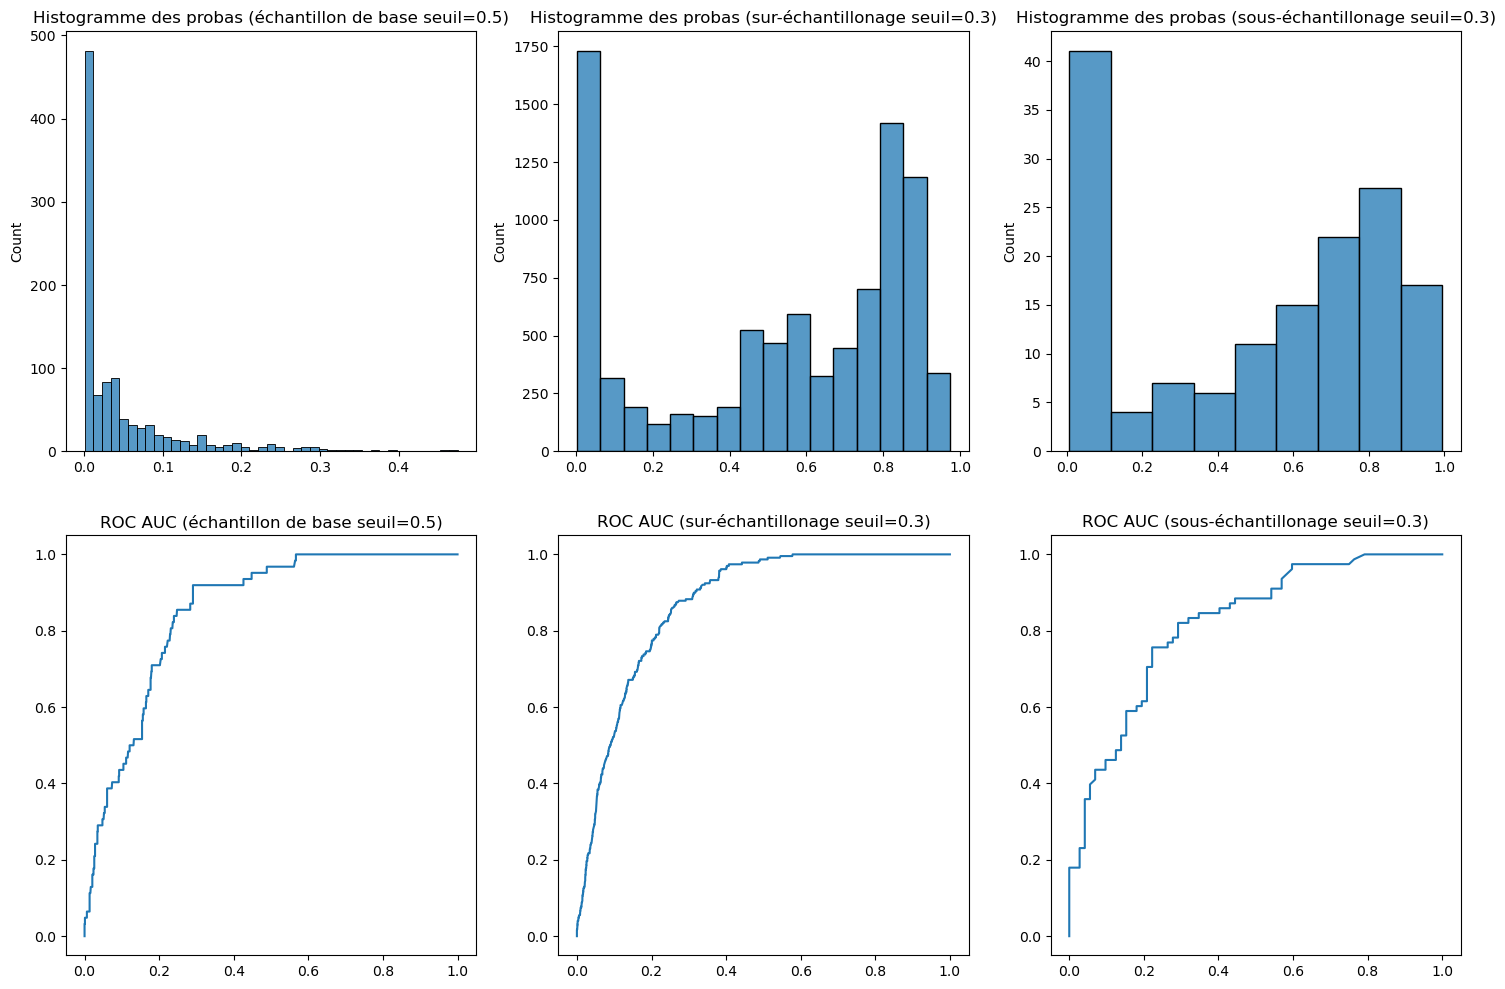

In [42]:
fig, axs = plt.subplots(2,3,figsize=(18,12))

sns.histplot (y_hat_proba_1, ax=axs [0, 0])
axs[0, 0].set_title('Histogramme des probas (échantillon de base seuil=0.5)')

sns.histplot(y_hat_proba_2, ax=axs[0, 1])
axs[0, 1].set_title('Histogramme des probas (sur-échantillonage seuil=0.3)')

sns.histplot(y_hat_proba_3, ax=axs [0, 2])
axs [0, 2].set_title('Histogramme des probas (sous-échantillonage seuil=0.3)')

axs [1, 0].plot(fpr_1, tpr_1)
axs [1, 0]. set_title('ROC AUC (échantillon de base seuil=0.5)')

axs [1, 1].plot(fpr_2, tpr_2)
axs[1, 1].set_title('ROC AUC (sur-échantillonage seuil=0.3)')

axs[1, 2].plot(fpr_3, tpr_3)
axs[1, 2].set_title('ROC AUC (sous-échantillonage seuil=0.3)')

plt.show()
